In [34]:
import sys
sys.path.append('/content/drive/MyDrive/Retinal_Vessel_Segmentation')
sys.path.append('/content/drive/MyDrive/Retinal_Vessel_Segmentation/libraries')

In [35]:
pip install tensorboardx

In [36]:
import joblib,copy
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torch,sys
from tqdm import tqdm
from collections import OrderedDict
from libraries.visualize import save_img,group_images,concat_result
import os
import argparse
from libraries.logger import Logger, Print_Logger
from libraries.extract_patches import *
from libraries.dataset import TestDataset
from libraries.metrics import Evaluate
from libraries.common import setpu_seed,dict_round
from libraries.pre_process import my_PreProc
#import models
from models import UNetFamily
#from models import LadderNet

from config import parse_args

setpu_seed(2021)

In [37]:
class Test():
    def __init__(self, test_data_path_list, outf, save, test_patch_height, test_patch_width, stride_height, stride_width, batch_size):
        #self.args = args
        self. test_data_path_list = test_data_path_list
        self.outf = outf
        self.save = save
        self.test_patch_height = test_patch_height
        self.test_patch_width = test_patch_width
        self.stride_height = stride_height
        self.stride_width = stride_width
        self.batch_size = batch_size

        #assert (args.stride_height <= args.test_patch_height and args.stride_width <= args.test_patch_width)
        assert (stride_height <= test_patch_height and stride_width <= test_patch_width)
        # save path
        self.path_experiment = os.path.join(outf, save)

        self.patches_imgs_test, self.test_imgs, self.test_masks, self.test_FOVs, self.new_height, self.new_width = get_data_test_overlap(
            test_data_path_list=test_data_path_list,
            patch_height=test_patch_height,
            patch_width=test_patch_width,
            stride_height=stride_height,
            stride_width=stride_width
        )
        self.img_height = self.test_imgs.shape[2]
        self.img_width = self.test_imgs.shape[3]

        test_set = TestDataset(self.patches_imgs_test)
        self.test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=3)

    # Inference prediction process
    def inference(self, net):
        net.eval()
        preds = []
        with torch.no_grad():
            for batch_idx, inputs in tqdm(enumerate(self.test_loader), total=len(self.test_loader)):
                inputs = inputs.cuda()
                outputs = net(inputs)
                outputs = outputs[:,1].data.cpu().numpy()
                preds.append(outputs)
        predictions = np.concatenate(preds, axis=0)
        self.pred_patches = np.expand_dims(predictions,axis=1)
        
    # Evaluate ate and visualize the predicted images
    def evaluate(self):
        self.pred_imgs = recompone_overlap(
            self.pred_patches, self.new_height, self.new_width, self.stride_height, self.stride_width)
        ## restore to original dimensions
        self.pred_imgs = self.pred_imgs[:, :, 0:self.img_height, 0:self.img_width]

        #predictions only inside the FOV
        y_scores, y_true = pred_only_in_FOV(self.pred_imgs, self.test_masks, self.test_FOVs)
        eval = Evaluate(save_path=self.path_experiment)
        eval.add_batch(y_true, y_scores)
        log = eval.save_all_result(plot_curve=True,save_name="performance.txt")
        # save labels and probs for plot ROC and PR curve when k-fold Cross-validation
        np.save('{}/result.npy'.format(self.path_experiment), np.asarray([y_true, y_scores]))
        return dict_round(log, 6)

    # save segmentation imgs
    def save_segmentation_result(self):
        img_path_list, _, _ = load_file_path_txt(self.test_data_path_list)
        img_name_list = [item.split('/')[-1].split('.')[0] for item in img_path_list]

        kill_border(self.pred_imgs, self.test_FOVs) # only for visualization
        self.save_img_path = os.path.join(self.path_experiment,'result_img')
        if not os.path.exists(os.path.join(self.save_img_path)):
            os.makedirs(self.save_img_path)
        # self.test_imgs = my_PreProc(self.test_imgs) # Uncomment to save the pre processed image
        for i in range(self.test_imgs.shape[0]):
            total_img = concat_result(self.test_imgs[i],self.pred_imgs[i],self.test_masks[i])
            save_img(total_img, os.path.join(self.save_img_path, "Result_"+img_name_list[i]+'.png'))

    # Val on the test set at each epoch
    def val(self):
        self.pred_imgs = recompone_overlap(
            self.pred_patches, self.new_height, self.new_width, self.args.stride_height, self.args.stride_width)
        ## recover to original dimensions
        self.pred_imgs = self.pred_imgs[:, :, 0:self.img_height, 0:self.img_width]

        #predictions only inside the FOV
        y_scores, y_true = pred_only_in_FOV(self.pred_imgs, self.test_masks, self.test_FOVs)
        eval = Evaluate(save_path=self.path_experiment)
        eval.add_batch(y_true, y_scores)
        confusion,accuracy,specificity,sensitivity,precision = eval.confusion_matrix()
        log = OrderedDict([('val_auc_roc', eval.auc_roc()),
                           ('val_f1', eval.f1_score()),
                           ('val_acc', accuracy),
                           ('SE', sensitivity),
                           ('SP', specificity)])
        return dict_round(log, 6)


# Configuration

In [38]:
test_data_path_list = '/content/drive/MyDrive/Retinal_Vessel_Segmentation/prepare_dataset/data_path_list/DRIVE/test.txt'
outf = "/content/drive/MyDrive/Retinal_Vessel_Segmentation/Experiments"
save = "UNet_vessel_seg"

test_patch_height = 64
test_patch_width = 64
stride_height = 16
stride_width = 16
batch_size = 64

save_path = os.path.join(outf, save)
sys.stdout = Print_Logger(os.path.join(save_path, 'test_log.txt'))
device = torch.device("cuda" if torch.cuda.is_available() and True else "cpu")

In [39]:
#Load the model architecture
#net = models.UNetFamily.U_Net(1,2).to(device)
#net = models.LadderNet(inplanes=1, num_classes=2, layers=3, filters=16).to(device)
net = UNetFamily.U_Net(1,2).to(device)
cudnn.benchmark = True

# Load checkpoint
print('==> Loading checkpoint...')
checkpoint = torch.load(os.path.join(save_path, 'best_model.pth'))
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [40]:
eval = Test(test_data_path_list, outf, save, test_patch_height, test_patch_width, stride_height, stride_width, batch_size)
eval.inference(net)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 351/351 [00:15<00:00, 21.95it/s]


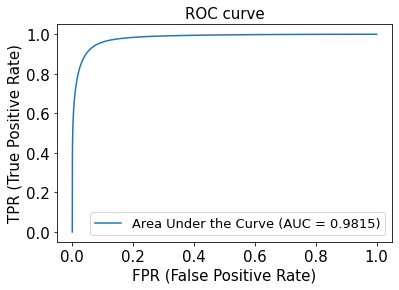

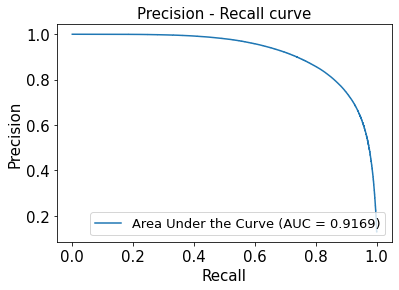

In [41]:
print(eval.evaluate())

In [42]:
eval.save_segmentation_result()